In [101]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

import matplotlib.pyplot as plt

In [102]:
X,y = fetch_openml(data_id=43843,return_X_y=True,as_frame=True)

X['LOCAL_DATE'] = pd.to_datetime(X['LOCAL_DATE'])

c:\Users\Jason\Desktop\git_control\ml-research\.venv\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [103]:
X.index = X['LOCAL_DATE'].values

In [104]:
X['MEAN_TEMPERATURE_TORONTO']

1940-01-01    -8.9
1940-01-02   -13.1
1940-01-03    -6.1
1940-01-04    -6.4
1940-01-05    -7.2
              ... 
2019-12-28     3.0
2019-12-29     1.1
2019-12-30     5.6
2019-12-31     0.4
2020-01-01    -1.7
Name: MEAN_TEMPERATURE_TORONTO, Length: 29221, dtype: float64

In [105]:
X['MEAN_TEMPERATURE_TORONTO'].fillna(method='ffill',inplace=True)

In [106]:
X['LOCAL_DATE'].dt.day_of_year

1940-01-01      1
1940-01-02      2
1940-01-03      3
1940-01-04      4
1940-01-05      5
             ... 
2019-12-28    362
2019-12-29    363
2019-12-30    364
2019-12-31    365
2020-01-01      1
Name: LOCAL_DATE, Length: 29221, dtype: int32

In [128]:

weeks = X['LOCAL_DATE'].dt.isocalendar().week
days = X['LOCAL_DATE'].dt.day_of_year

def sinu_feat(x,period=1,freq=53,func='sin'):

    if func=='sin':
        f = np.sin
    else:
        f = np.cos

    return f(2*np.pi*period*(x)/freq)

feats = pd.DataFrame()
for f in ['sin','cos']:
    for p in [1]:#,2,3,5,7]:
        feats[f"SINU_{f.upper()}_{str(p)}"] = sinu_feat(days,period=p,freq=365.25,func=f)

feats['WEEKS_SINCE_1940'] = (X['LOCAL_DATE'] - pd.to_datetime('1940-01-01')).dt.days



In [129]:
feats

,SINU_SIN_1,SINU_COS_1,WEEKS_SINCE_1940
1940-01-01,0.017202,0.999852,0
1940-01-02,0.034398,0.999408,1
1940-01-03,0.051584,0.998669,2
1940-01-04,0.068755,0.997634,3
1940-01-05,0.085906,0.996303,4
...,...,...,...
2019-12-28,-0.055879,0.998438,29216
2019-12-29,-0.038696,0.999251,29217
2019-12-30,-0.021501,0.999769,29218
2019-12-31,-0.004301,0.999991,29219


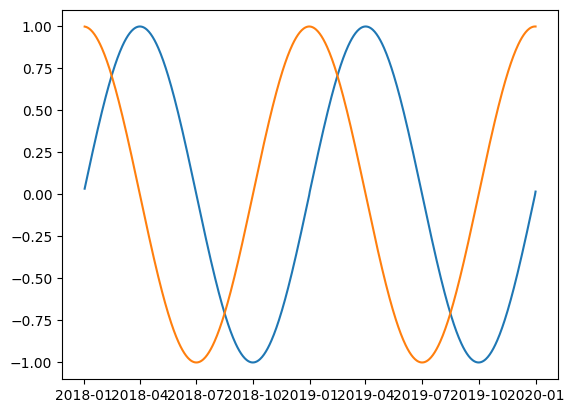

In [130]:
for f in feats.columns:
    if 'SINU' in f:
        plt.plot(feats[feats.index>'2018-01-01'][f])

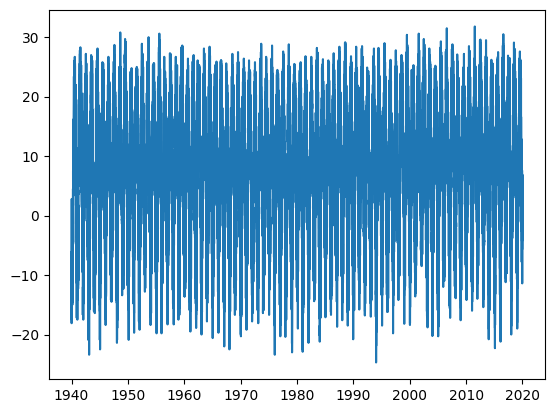

In [131]:
plt.plot(X['MEAN_TEMPERATURE_TORONTO'])

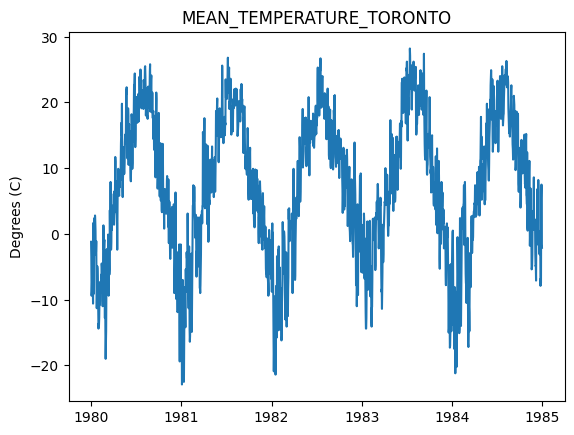

In [132]:
plt.plot(X[(X.index>='1980-01-01')&(X.index<'1985-01-01')]['MEAN_TEMPERATURE_TORONTO'])
plt.title('MEAN_TEMPERATURE_TORONTO')
plt.ylabel("Degrees (C)")
plt.show()

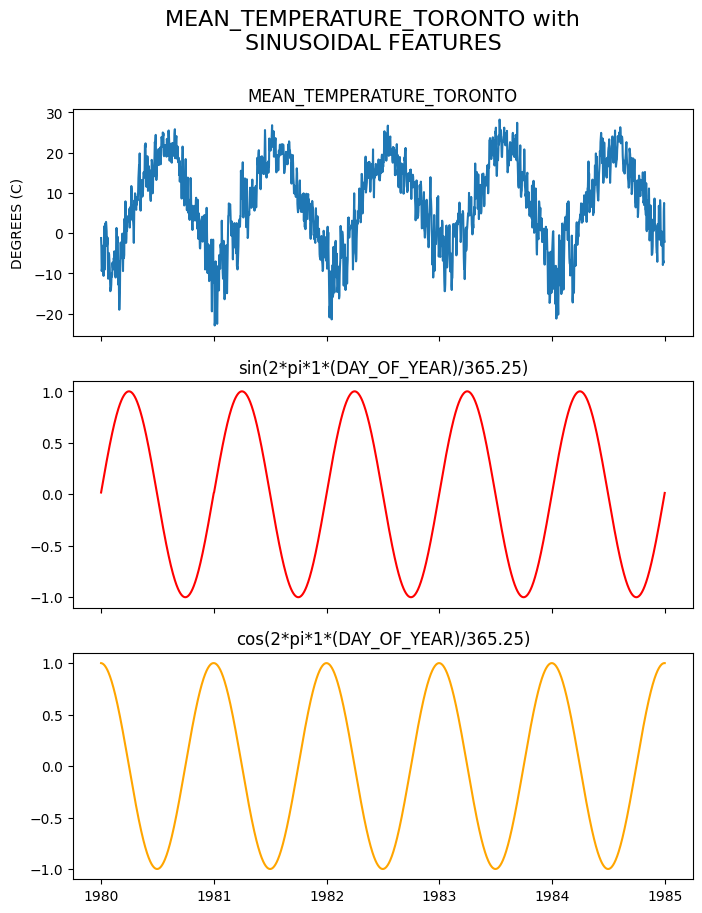

In [133]:
mask = (X.index>='1980-01-01')&(X.index<'1985-01-01')
fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(8,10))
fig.suptitle('MEAN_TEMPERATURE_TORONTO with\nSINUSOIDAL FEATURES', size=16)
axs[0].plot(X[mask]['MEAN_TEMPERATURE_TORONTO'])
axs[0].set_ylabel("DEGREES (C)")
axs[0].set_title("MEAN_TEMPERATURE_TORONTO")
axs[1].plot(feats[mask]['SINU_SIN_1'],color='red')
axs[1].set_title("sin(2*pi*1*(DAY_OF_YEAR)/365.25)")
axs[2].plot(feats[mask]['SINU_COS_1'],color='orange')
axs[2].set_title("cos(2*pi*1*(DAY_OF_YEAR)/365.25)")
fig.align_ylabels()

In [134]:
Xtrain,Xtest,ytrain,ytest = train_test_split(feats,X['MEAN_TEMPERATURE_TORONTO'],test_size=365*3,random_state=42,shuffle=False)

In [135]:
model = Pipeline(
    steps = [
        ('scaler',MinMaxScaler()),
        ('learner',LinearRegression())
    ]
).fit(Xtrain,ytrain)

In [136]:
yfit = pd.Series(model.predict(Xtrain),index=Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index=Xtest.index)

yout = pd.concat([yfit,ypred])

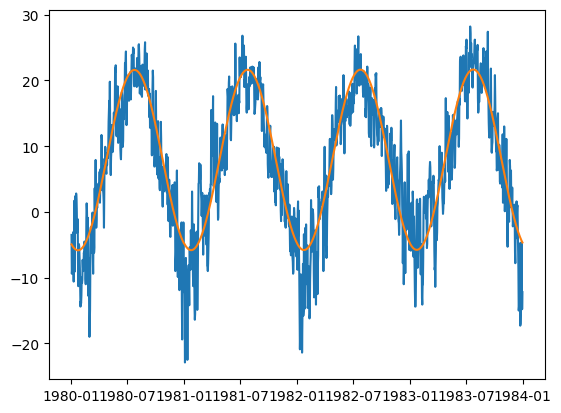

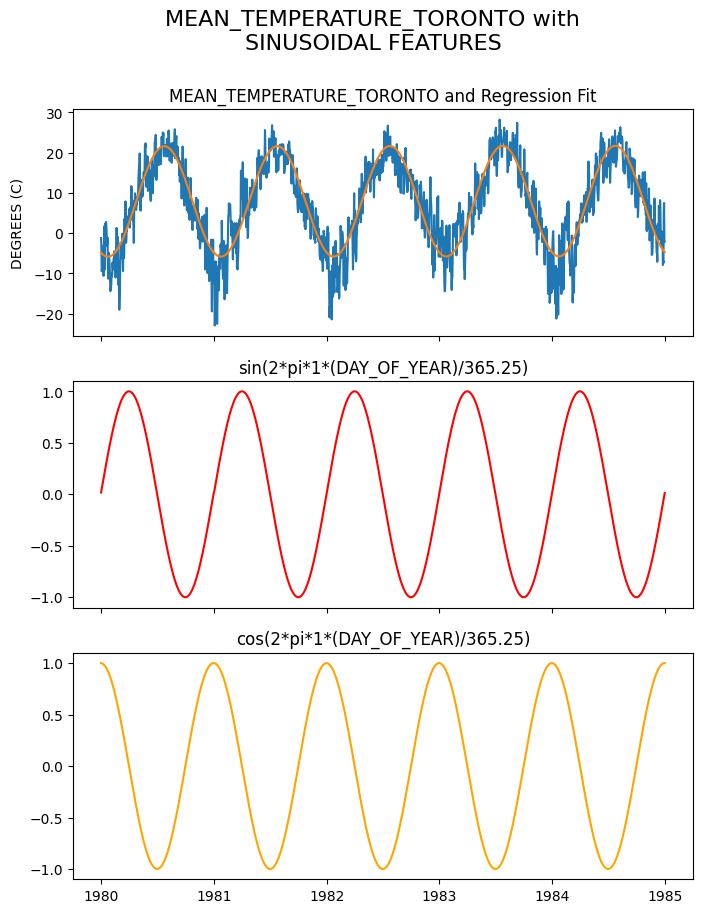

In [140]:
mask = (X.index>'1980-01-01')&(X.index<'1984-01-01')
mask2 = (yfit.index>'1980-01-01')&(yfit.index<'1984-01-01')

plt.plot(X[mask]['MEAN_TEMPERATURE_TORONTO'])
plt.plot(yfit[mask2])
#plt.plot(ypred)
plt.show()

mask = (X.index>='1980-01-01')&(X.index<'1985-01-01')
mask2 = (yfit.index>='1980-01-01')&(yfit.index<'1985-01-01')
fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(8,10))
fig.suptitle('MEAN_TEMPERATURE_TORONTO with\nSINUSOIDAL FEATURES', size=16)
axs[0].plot(X[mask]['MEAN_TEMPERATURE_TORONTO'])
axs[0].plot(yfit[mask2])
axs[0].set_ylabel("DEGREES (C)")
axs[0].set_title("MEAN_TEMPERATURE_TORONTO and Regression Fit")
axs[1].plot(feats[mask]['SINU_SIN_1'],color='red')
axs[1].set_title("sin(2*pi*1*(DAY_OF_YEAR)/365.25)")
axs[2].plot(feats[mask]['SINU_COS_1'],color='orange')
axs[2].set_title("cos(2*pi*1*(DAY_OF_YEAR)/365.25)")
fig.align_ylabels()

In [87]:
model['learner'].coef_

array([-10.65556684,  -0.73393089,  -0.85597256,   0.33016933,
        -0.08376153, -25.26549339,  -0.36019476,   0.103451  ,
        -0.24919618,   0.18174646,   1.68259218])

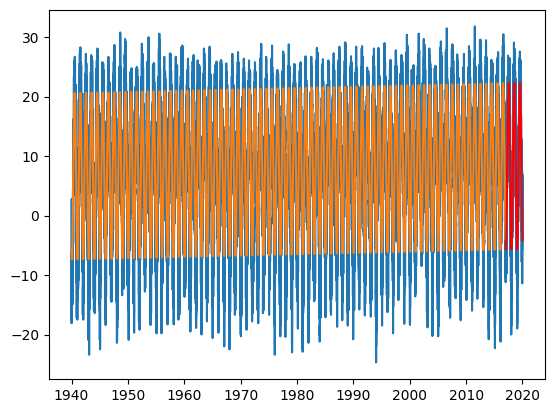

In [88]:

plt.plot(X[:]['MEAN_TEMPERATURE_TORONTO'])
plt.plot(yfit[:])
plt.plot(ypred,color='red')

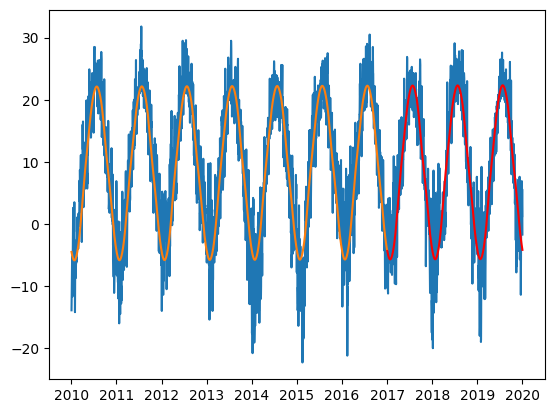

In [89]:
mask = (X.index>'2010-01-01')
mask2 = (yfit.index>'2010-01-01')
plt.plot(X[mask]['MEAN_TEMPERATURE_TORONTO'])
plt.plot(yfit[mask2])
plt.plot(ypred,color='r')

In [90]:
resid = yout - X['MEAN_TEMPERATURE_TORONTO']

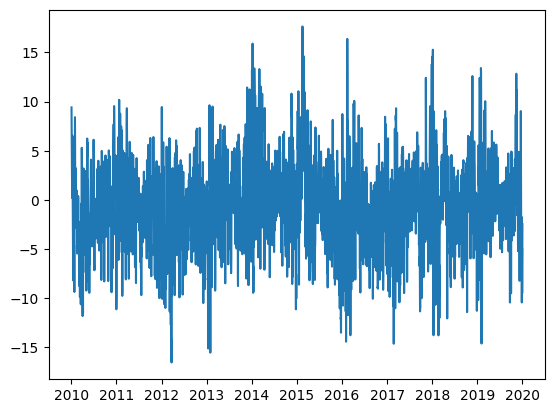

In [91]:
plt.plot(resid[mask])

In [92]:
feats2 = feats.copy()
feats2['WEEK'] = weeks
Xtrain2,Xtest2,rtrain,rtest = train_test_split(feats2.drop('WEEKS_SINCE_1940',axis=1),
                                             resid,test_size=365*3,random_state=42,shuffle=False)

In [93]:
model_resid = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=3,interaction_only=False,include_bias=True)),
        ('scaler',MinMaxScaler()),
        ('learner',LinearRegression()),
        #('learner',RandomForestRegressor(random_state=42,
        #                                 #max_depth=50,min_samples_leaf=5
        #                                 ))
    ]
).fit(Xtrain2,rtrain)

In [94]:
rfit = pd.Series(model_resid.predict(Xtrain2),index = Xtrain2.index)
rpred = pd.Series(model_resid.predict(Xtest2),index = Xtest2.index)

rout = pd.concat([rfit,rpred])

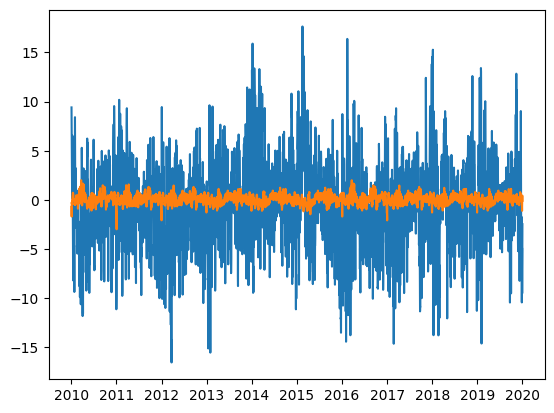

In [95]:
plt.plot(resid[mask])
plt.plot(rout[mask])

In [96]:
yfit2 = yfit + rfit
ypred2 = ypred + rpred

yout2 = pd.concat([yfit2,ypred2])

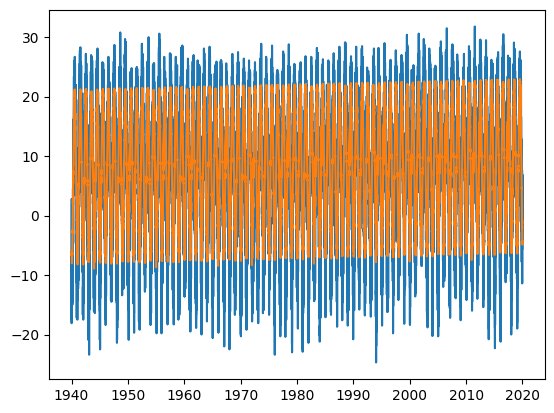

In [97]:

plt.plot(X[:]['MEAN_TEMPERATURE_TORONTO'])
plt.plot(yout2)

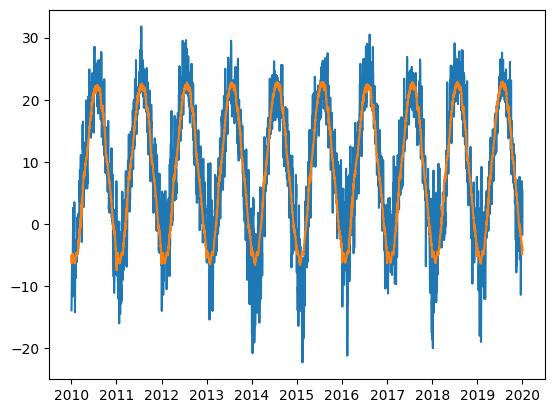

In [98]:

plt.plot(X[mask]['MEAN_TEMPERATURE_TORONTO'])
plt.plot(yout2[mask])

In [99]:
r2_score(ytest,ypred)

0.8289062149696376

In [100]:
r2_score(ytest,ypred2)

0.8273912551083783

In [ ]:

plt.plot(X['MEAN_TEMPERATURE_TORONTO'])
plt.plot(X['MEAN_TEMPERATURE_TORONTO'].rolling(window=365*2,min_periods=365).mean())

In [ ]:
from scipy.signal import step
from numpy import convolve

In [ ]:
n = 365*5

filter = np.concatenate(
    [
        np.ones(n),
        -np.ones(n)
    ]
)

In [ ]:
tgt = X['MEAN_TEMPERATURE_TORONTO'].rolling(window=365*2,min_periods=365).mean().dropna()

In [ ]:
tgt

In [ ]:
conv_tgt = pd.Series(convolve(tgt,filter,mode='full')[:len(tgt)],index = tgt.index)

In [ ]:
plt.plot(convolve(tgt,filter,mode='full'))

In [ ]:
fig,ax1 = plt.subplots()
ax1.plot(conv_tgt[conv_tgt.index>='1960-01-01'],color='blue')
ax2=ax1.twinx()
ax2.plot(tgt,color='red')
plt.show()

In [ ]:
a = pd.Series(np.array([100,100,100,0,0]))
b = np.array([1/3,1/3,1/3])
convolve(a,b)[:len(a)]

In [ ]:
a = pd.Series(np.array([100,0,0,0,0]))
b = np.array([1,.5,.25,.125])
convolve(a,b,mode='full')